In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [71]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Define paths
DATA_PATH_G = "./data/games.csv"
DATA_PATH_T = "./data/teams.csv"
OUTPUT_DIR = "./output"
PLOTS_DIR = "./plots"

In [3]:
games = pd.read_csv(DATA_PATH_G)
teams = pd.read_csv(DATA_PATH_T)

In [61]:
#reused code that sucheer wrote cuz its clean lol

home = games[['SEASON', 'HOME_TEAM_ID', 'PTS_home', 'FG_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']].copy()
home = home.rename(columns={
    'HOME_TEAM_ID': 'TEAM_ID',
    'PTS_home': 'PTS',
    'FG_PCT_home': 'FG_PCT',
    'AST_home': 'AST',
    'REB_home': 'REB',
    'HOME_TEAM_WINS': 'WIN'
})

away = games[['SEASON', 'VISITOR_TEAM_ID', 'PTS_away', 'FG_PCT_away', 'AST_away', 'REB_away', 'HOME_TEAM_WINS']].copy()
away = away.rename(columns={
    'VISITOR_TEAM_ID': 'TEAM_ID',
    'PTS_away': 'PTS',
    'FG_PCT_away': 'FG_PCT',
    'AST_away': 'AST',
    'REB_away': 'REB'
})

away['WIN'] = 1 - away['HOME_TEAM_WINS']

all_games = pd.concat([home, away], ignore_index=True)

agg_stats = all_games.groupby(['SEASON', 'TEAM_ID']).agg(
    wins=('WIN', 'sum'),
    avg_pts=('PTS', 'mean'),
    avg_fg_pct=('FG_PCT', 'mean'),
    avg_ast=('AST', 'mean'),
    avg_reb=('REB', 'mean')
).reset_index()
agg_stats = agg_stats.merge(teams, on='TEAM_ID', how='left')

X = agg_stats[['avg_pts', 'avg_fg_pct', 'avg_ast', 'avg_reb']]
y = agg_stats['wins']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [62]:
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(407, 4) (407,)
(102, 4) (102,)


In [74]:
X_train_scaled
X_test_scaled

array([[-1.97118386e+00, -7.16441765e-01, -1.68603799e+00,
        -2.34055973e+00],
       [-2.51100327e-01, -1.33613050e+00,  2.23030146e-03,
         1.55010935e-01],
       [ 8.92779675e-01, -1.31508682e+00,  1.55090018e+00,
         3.54608201e-01],
       [ 2.21265676e+00,  4.22099247e-01,  1.28672957e+00,
         9.47351597e-01],
       [-5.98447036e-01,  3.65224338e-01, -9.00567321e-01,
        -8.05691772e-01],
       [ 6.79325120e-01, -7.70191913e-01,  4.44915393e-02,
         1.84183465e+00],
       [-5.21764037e-01, -5.02631917e-01, -1.10466333e-01,
        -1.19249603e-02],
       [ 9.54725884e-01,  1.06264388e+00, -4.35851556e-01,
        -5.93908568e-01],
       [-1.39861747e+00, -6.84879846e-01, -1.63934943e-01,
        -3.02125929e-01],
       [-1.48667026e-01,  5.80370325e-01, -5.52030497e-01,
         2.33054421e-01],
       [-1.08964077e+00, -7.48026405e-01,  4.17310975e-01,
        -8.60509773e-01],
       [-3.77599997e-01, -7.12707595e-01, -1.37412279e+00,
      

In [63]:
agg_stats

,SEASON,TEAM_ID,wins,avg_pts,avg_fg_pct,avg_ast,avg_reb,LEAGUE_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,2003,1610612737,33,92.662651,0.432747,20.072289,42.746988,0,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,2003,1610612738,40,94.689655,0.442609,20.390805,40.126437,0,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,2003,1610612739,41,92.880952,0.435357,22.071429,45.642857,0,1970,2019,CLE,Cavaliers,1970,Cleveland,Quicken Loans Arena,20562.0,Dan Gilbert,Koby Altman,John Beilein,Canton Charge
3,2003,1610612740,50,91.088889,0.419767,20.866667,42.711111,0,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
4,2003,1610612741,26,89.313253,0.416530,21.722892,43.349398,0,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2019,1610612762,37,111.507937,0.474190,22.111111,45.460317,0,1974,2019,UTA,Jazz,1974,Utah,Vivint Smart Home Arena,20148.0,Greg Miller,Dennis Lindsey,Quin Snyder,Salt Lake City Stars
505,2019,1610612763,30,112.079365,0.467730,26.841270,46.476190,0,1995,2019,MEM,Grizzlies,1995,Memphis,FedExForum,18119.0,Robert Pera,Zach Kleiman,Taylor Jenkins,Memphis Hustle
506,2019,1610612764,24,115.460317,0.462016,25.412698,42.238095,0,1961,2019,WAS,Wizards,1961,Washington,Capital One Arena,20647.0,Ted Leonsis,Tommy Sheppard,Scott Brooks,Capital City Go-Go
507,2019,1610612765,23,107.492537,0.458299,24.134328,42.417910,0,1948,2019,DET,Pistons,1948,Detroit,Little Caesars Arena,21000.0,Tom Gores,Ed Stefanski,Dwane Casey,Grand Rapids Drive


X_train shape: (407, 4)
y_train shape: (407,)
X_test  shape: (102, 4)
y_test  shape: (102,)

=== Running Grid Search for Hyperparameter Tuning ===
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best RMSE: 13.8560
Grid search took 1.73 seconds

=== Training Final Model with Best Parameters ===

=== Final Model Results ===
RMSE: 14.2236
MAE: 11.0854
R²: 0.2997

=== Feature Importances (gain) ===
                    avg_fg_pct: 0.4911
                       avg_reb: 0.2050
                       avg_pts: 0.1555
                       avg_ast: 0.1484


/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


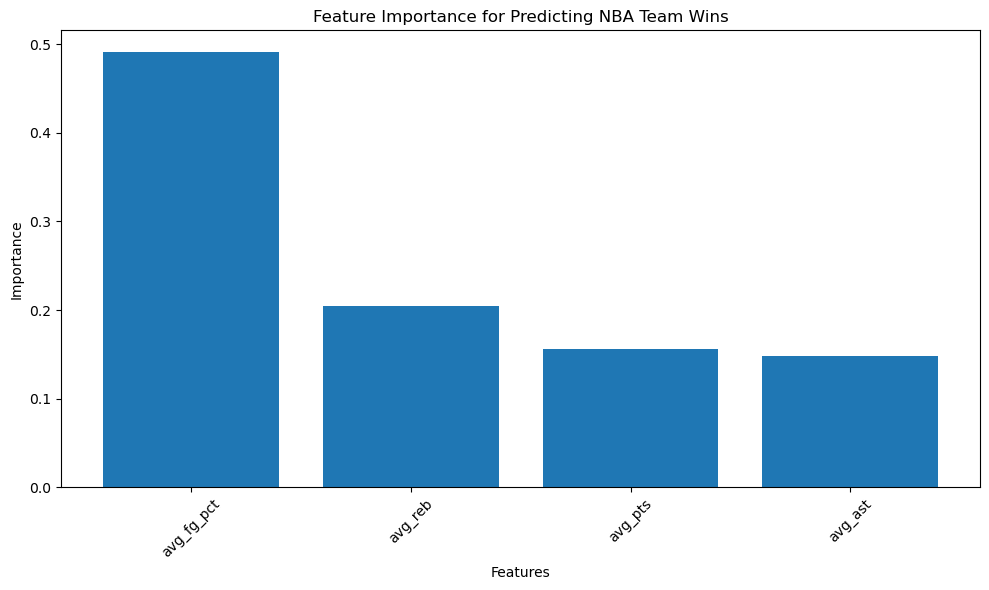

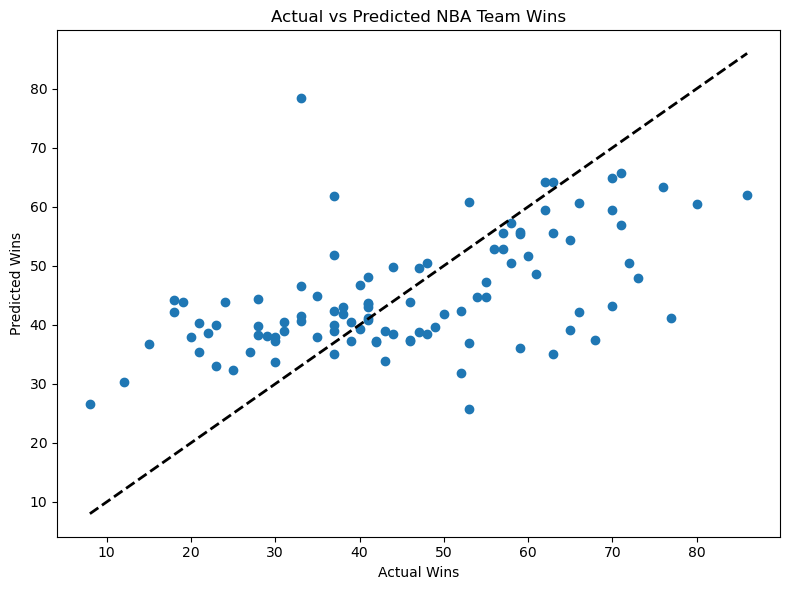

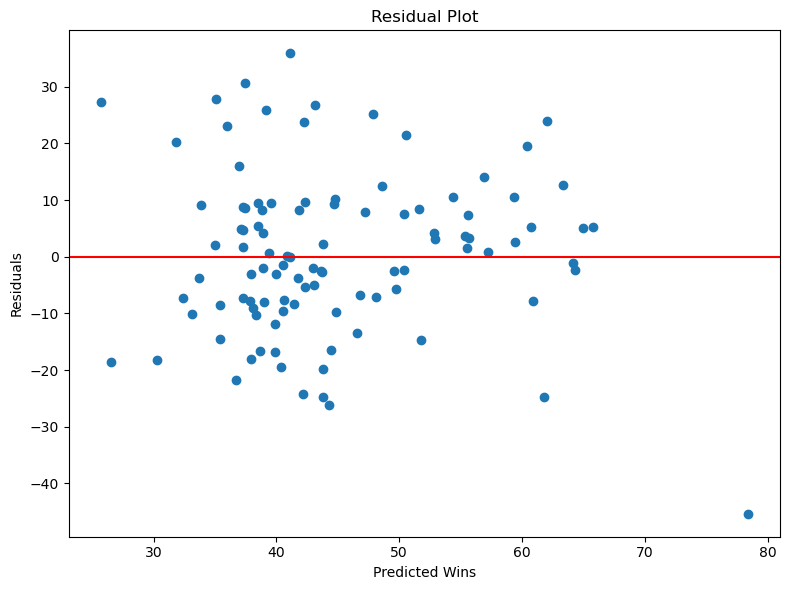

In [79]:

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

X = agg_stats[['avg_pts', 'avg_fg_pct', 'avg_ast', 'avg_reb']]
y = agg_stats['wins']

feature_names = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test  shape: {y_test.shape}")



print("\n=== Running Grid Search for Hyperparameter Tuning ===")
start_time = time()

param_grid = {
    'max_depth': [3, 5, 7],          # Tree depth
    'learning_rate': [0.05, 0.1],     # Learning rate (eta)
    'n_estimators': [100, 200],       # Number of trees
    'subsample': [0.8, 1.0],          # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0]    # Fraction of features used per tree
}

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    seed=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  
    cv=5,                             
    verbose=1,
    n_jobs=-1                        
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.4f}")
print(f"Grid search took {time() - start_time:.2f} seconds")


print("\n=== Training Final Model with Best Parameters ===")

best_params = grid_search.best_params_
final_model = XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    seed=42
)

final_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False
)

y_pred = final_model.predict(X_test)

print("\n=== Final Model Results ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse_xg = rmse**2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

print("\n=== Feature Importances (gain) ===")
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(len(feature_names)):
    print(f"{feature_names[indices[i]]:>30}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), importances[indices], align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for Predicting NBA Team Wins')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Actual vs Predicted NBA Team Wins')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

In [75]:
def bias_variance_decomp(X, y, model_constructor, n_splits=5, max_depths=[1, 3, 5, 7, 9, 11]):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = {
        'max_depth': [],
        'train_error': [],
        'test_error': [],
        'bias_squared': [],
        'variance': [],
    }
    
    for depth in max_depths:
        print(f"Analyzing max_depth={depth}...")
        
        train_errors = []
        test_errors = []
        
        all_predictions = np.zeros((len(X), n_splits))
        fold_idx = 0
        
        for train_idx, test_idx in kf.split(X):
            X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
            
            model = model_constructor(max_depth=depth)
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_test_fold, y_test_fold)],
                early_stopping_rounds=10,
                verbose=False
            )
            
            train_error = mean_squared_error(y_train_fold, model.predict(X_train_fold))
            test_error = mean_squared_error(y_test_fold, model.predict(X_test_fold))
            
            train_errors.append(train_error)
            test_errors.append(test_error)
            
            all_predictions[:, fold_idx] = model.predict(X)
            fold_idx += 1
        
        avg_train_error = np.mean(train_errors)
        avg_test_error = np.mean(test_errors)
        
        avg_predictions = np.mean(all_predictions, axis=1)  # Average prediction per sample
        variance = np.mean(np.var(all_predictions, axis=1, ddof=1))  # Variance of predictions
        bias_squared = np.mean((y.values - avg_predictions) ** 2)  # Squared bias
        
        results['max_depth'].append(depth)
        results['train_error'].append(avg_train_error)
        results['test_error'].append(avg_test_error)
        results['bias_squared'].append(bias_squared)
        results['variance'].append(variance)
    
    return results

def run_bias_variance_analysis(X, y):
    def create_model(max_depth=3):
        return xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.1,
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=max_depth,
            random_state=42
        )
    
    max_depths = [1, 2, 3, 5, 7, 10]
    
    print("Running bias-variance decomposition...")
    results = bias_variance_decomp(X, y, create_model, max_depths=max_depths)
    
    results_df = pd.DataFrame(results)
    print("\nResults:")
    print(results_df)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(results['max_depth'], results['bias_squared'], 'o-', label='Bias²')
    plt.plot(results['max_depth'], results['variance'], 'o-', label='Variance')
    plt.plot(results['max_depth'], np.array(results['bias_squared']) + np.array(results['variance']), 
             'o-', label='Total Error')
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Error')
    plt.title('Bias-Variance Tradeoff by Tree Depth')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(results['max_depth'], results['train_error'], 'o-', label='Train Error')
    plt.plot(results['max_depth'], results['test_error'], 'o-', label='Test Error')
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Mean Squared Error')
    plt.title('Training vs Test Error by Tree Depth')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    optimal_idx = np.argmin(results['test_error'])
    optimal_depth = results['max_depth'][optimal_idx]
    print(f"\nOptimal max_depth: {optimal_depth}")
    print(f"At this depth:")
    print(f"  Bias²: {results['bias_squared'][optimal_idx]:.4f}")
    print(f"  Variance: {results['variance'][optimal_idx]:.4f}")
    print(f"  Test Error: {results['test_error'][optimal_idx]:.4f}")
    
    return results_df, optimal_depth

Running bias-variance decomposition...
Analyzing max_depth=1...
Analyzing max_depth=2...


/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility

Analyzing max_depth=3...
Analyzing max_depth=5...


/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility

Analyzing max_depth=7...


/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Analyzing max_depth=10...


/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/ronaldfeng/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility


Results:
   max_depth  train_error  test_error  bias_squared   variance
0          1   168.322730  191.382656    170.268071   3.321417
1          2   148.337651  193.627661    154.477336   3.640231
2          3   128.843287  198.975688    138.168307   5.869621
3          5    79.525374  208.587521     95.211025  12.648714
4          7    44.144859  212.509299     62.373513  19.296609
5         10    24.739750  216.789253     43.151911  24.995924


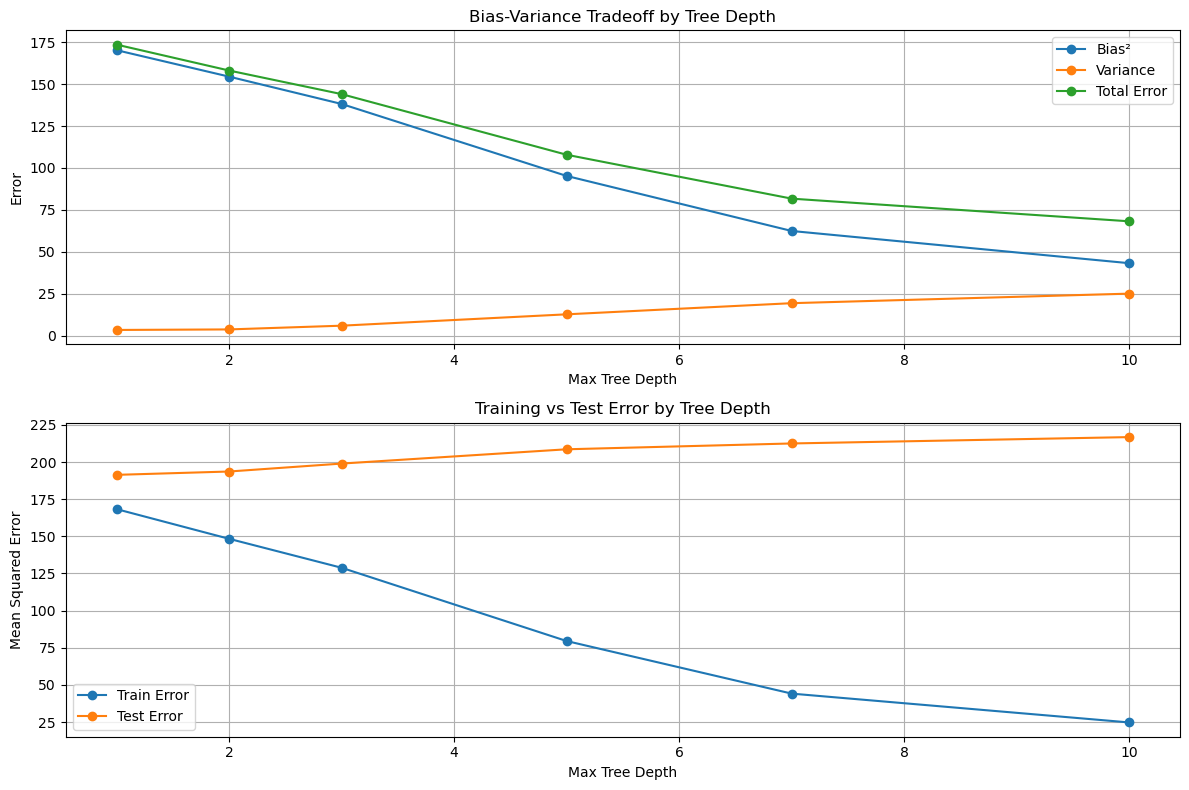


Optimal max_depth: 1
At this depth:
  Bias²: 170.2681
  Variance: 3.3214
  Test Error: 191.3827


In [76]:
results_df, optimal_depth = run_bias_variance_analysis(X, y)

In [11]:
#KNN
knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_test, y_pred_knn)

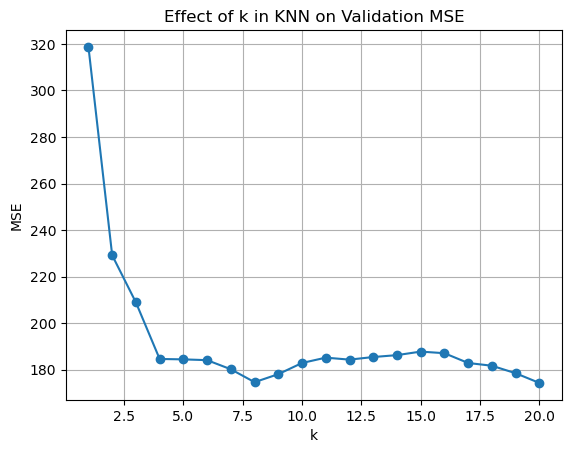

In [21]:
k_values = list(range(1, 21))
mse_values = []

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mse_values.append(mean_squared_error(y_test, preds))

plt.figure()
plt.plot(k_values, mse_values, marker='o')
plt.title("Effect of k in KNN on Validation MSE")
plt.xlabel("k")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


In [15]:
#SVR
svr = SVR(kernel='rbf', C=1.0, gamma='scale')
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test, y_pred_svr)

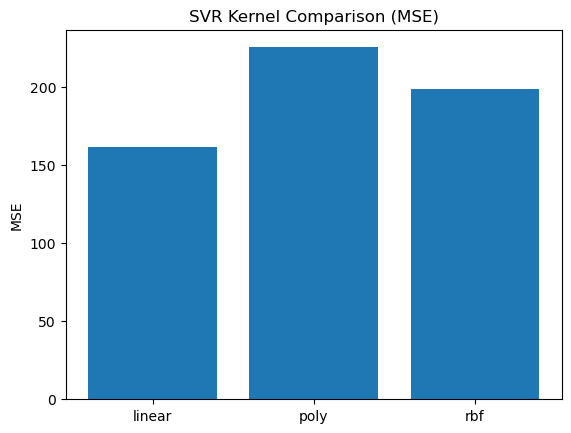

In [16]:
svr_linear = SVR(kernel='linear').fit(X_train_scaled, y_train)
svr_poly = SVR(kernel='poly', degree=3).fit(X_train_scaled, y_train)
svr_rbf = SVR(kernel='rbf').fit(X_train_scaled, y_train)

mse_linear = mean_squared_error(y_test, svr_linear.predict(X_test_scaled))
mse_poly = mean_squared_error(y_test, svr_poly.predict(X_test_scaled))
mse_rbf = mean_squared_error(y_test, svr_rbf.predict(X_test_scaled))

plt.figure()
plt.bar(['linear', 'poly', 'rbf'], [mse_linear, mse_poly, mse_rbf])
plt.title("SVR Kernel Comparison (MSE)")
plt.ylabel("MSE")
plt.show()

In [17]:
#DTR
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)

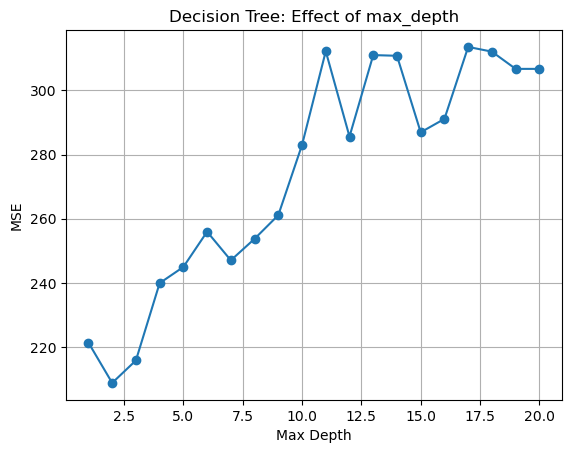

In [18]:
depths = range(1, 21)
mse_depth = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse_depth.append(mean_squared_error(y_test, preds))

plt.figure()
plt.plot(depths, mse_depth, marker='o')
plt.title("Decision Tree: Effect of max_depth")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

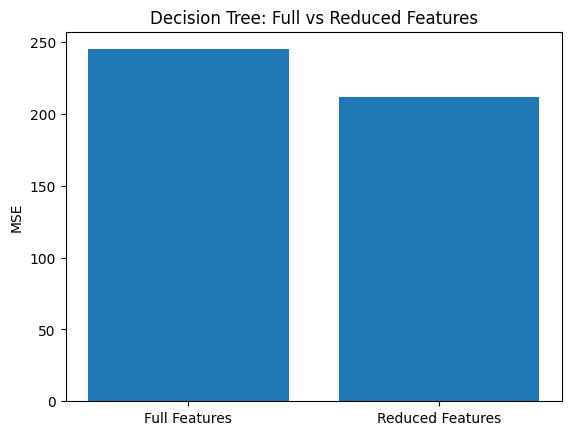

In [21]:
X_reduced = X[['avg_pts', 'avg_fg_pct']]  # Reduce from 4 → 2 features
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

model_full = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)
model_reduced = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train_r, y_train_r)

mse_full = mean_squared_error(y_test, model_full.predict(X_test))
mse_reduced = mean_squared_error(y_test_r, model_reduced.predict(X_test_r))

plt.bar(['Full Features', 'Reduced Features'], [mse_full, mse_reduced])
plt.title("Decision Tree: Full vs Reduced Features")
plt.ylabel("MSE")
plt.show()

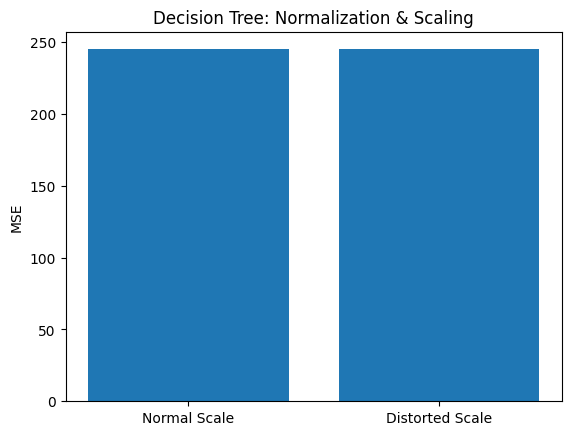

In [22]:
X_distorted = X.copy()
X_distorted['avg_ast'] *= 1000  # Artificial scaling distortion

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_distorted, y, test_size=0.2, random_state=42)

model_normal = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)
model_distorted = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train_d, y_train_d)

mse_normal = mean_squared_error(y_test, model_normal.predict(X_test))
mse_distorted = mean_squared_error(y_test_d, model_distorted.predict(X_test_d))

plt.bar(['Normal Scale', 'Distorted Scale'], [mse_normal, mse_distorted])
plt.title("Decision Tree: Normalization & Scaling")
plt.ylabel("MSE")
plt.show()

In [14]:
#FEATURE REDUCTION
X_reduced = X[['avg_pts', 'avg_fg_pct']]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
X_train_r_scaled = scaler.fit_transform(X_train_r)
X_test_r_scaled = scaler.transform(X_test_r)

model_knn_reduced = KNeighborsRegressor(n_neighbors=5).fit(X_train_r_scaled, y_train_r)
mse_knn_reduced = mean_squared_error(y_test_r, model_knn_reduced.predict(X_test_r_scaled))


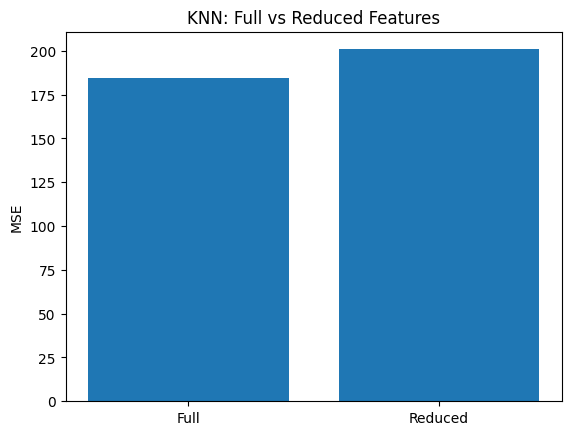

In [15]:
#COMPARE PLOT BETWEEN FULL AND REDUCED
plt.figure()
plt.bar(['Full', 'Reduced'], [mse_knn, mse_knn_reduced])
plt.title("KNN: Full vs Reduced Features")
plt.ylabel("MSE")
plt.show()


In [16]:
#SUMMARY STATS
print("Final MSE Summary:")
print(f"KNN (k=5): {mse_knn:.2f}")
print(f"SVR (RBF): {mse_svr:.2f}")
print(f"Decision Tree (depth=5): {mse_dt:.2f}")
print(f"KNN with reduced features: {mse_knn_reduced:.2f}")
print(f"SVR (linear): {mse_linear:.2f}, poly: {mse_poly:.2f}, rbf: {mse_rbf:.2f}")

Final MSE Summary:
KNN (k=5): 184.46
SVR (RBF): 198.36
Decision Tree (depth=5): 244.95
KNN with reduced features: 200.92
SVR (linear): 161.68, poly: 225.26, rbf: 198.36


In [17]:
X_distorted = X.copy()
X_distorted['avg_ast'] *= 100
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_distorted, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_d_scaled = scaler.fit_transform(X_train_d)
X_test_d_scaled = scaler.transform(X_test_d)

model_distorted = KNeighborsRegressor(n_neighbors=5).fit(X_train_d_scaled, y_train_d)
mse_distorted = mean_squared_error(y_test_d, model_distorted.predict(X_test_d_scaled))

Text(0, 0.5, 'MSE')

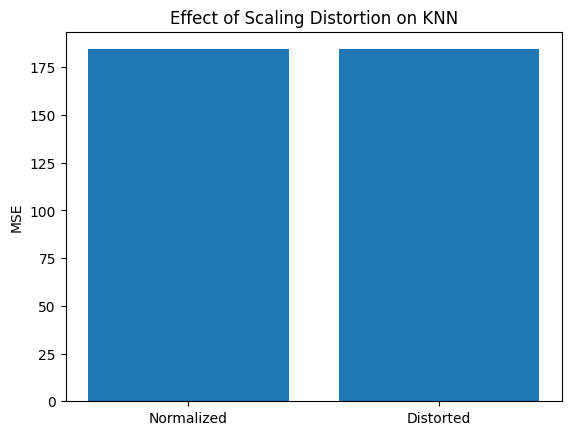

In [18]:
plt.bar(['Normalized', 'Distorted'], [mse_knn, mse_distorted])
plt.title("Effect of Scaling Distortion on KNN")
plt.ylabel("MSE")

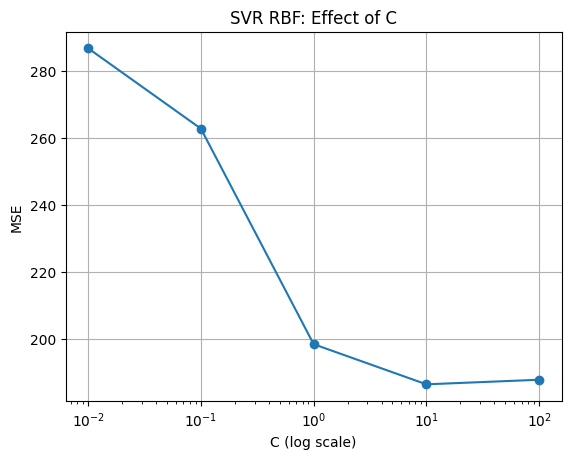

In [19]:
C_vals = [0.01, 0.1, 1, 10, 100]
mse_c = []

for c in C_vals:
    svr = SVR(kernel='rbf', C=c)
    svr.fit(X_train_scaled, y_train)
    preds = svr.predict(X_test_scaled)
    mse_c.append(mean_squared_error(y_test, preds))

plt.plot(C_vals, mse_c, marker='o')
plt.xscale('log')
plt.title("SVR RBF: Effect of C")
plt.xlabel("C (log scale)")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

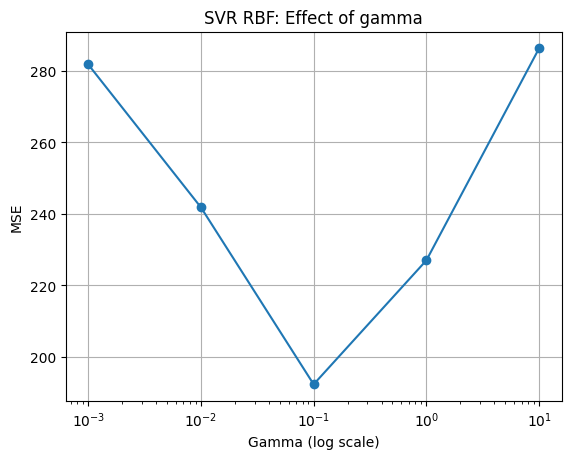

In [20]:
gamma_vals = [0.001, 0.01, 0.1, 1, 10]
mse_gamma = []

for g in gamma_vals:
    svr = SVR(kernel='rbf', gamma=g)
    svr.fit(X_train_scaled, y_train)
    preds = svr.predict(X_test_scaled)
    mse_gamma.append(mean_squared_error(y_test, preds))

plt.plot(gamma_vals, mse_gamma, marker='o')
plt.xscale('log')
plt.title("SVR RBF: Effect of gamma")
plt.xlabel("Gamma (log scale)")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

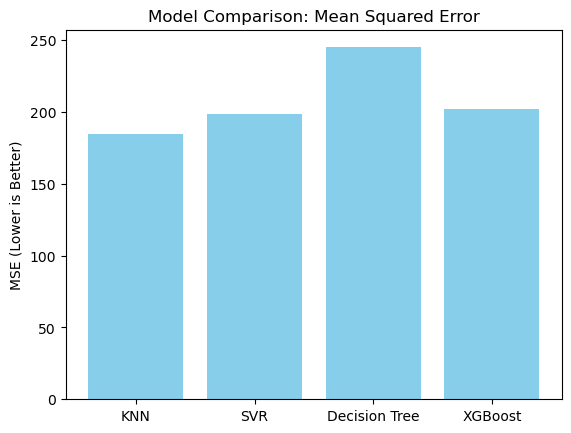

In [80]:
import matplotlib.pyplot as plt

models = ['KNN', 'SVR', 'Decision Tree', 'XGBoost']
mse_scores = [mse_knn, mse_svr, mse_dt, mse_xg]

plt.bar(models, mse_scores, color='skyblue')
plt.title("Model Comparison: Mean Squared Error")
plt.ylabel("MSE (Lower is Better)")
plt.show()